# K-means analysis

We used k-means to cluster our 58 seed regions. This notebook will rely on custom functions, but they are essentially wrapped around Scikit-learn's KMeans function. It is important to note that k-means is not guaranteed to find the optimal solution and may fall into local maxima. As recommended by (Nanetti et al., 2009), we ran k-means 256 times to find the most stable solution. Since this many iterations takes a few hours to calculate, the k-means data will be available in this repository. However, this notebook will demonstrate how the custom function works using just 1 iteration.

## Initialization

In [1]:
#Prep work
import sys
sys.path.append('..')
import proj_utils as putils
import kmeansUtils as kutils
import pickle as pkl
import pandas as pd

with open("../pData.pkl", "rb") as f:
    pData = pkl.load(f)
seed_list = pData['newNames']
seed_coords = pData['coordsMNI']
palette = pData['catColors']

C:\Users\ixa080020\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data
Now we'll load in the data. The Jaccard similarity index measures how similar two sets are. Given two sets X and Y, the Jaccard index is the intersection X and Y divided by their union,

$$J(X,Y) = \frac{|X \cap Y|}{|X \cup Y|}$$ 

In this case, our Xs are second-level t-test masks for each cingulate seed, and our Ys are masks corresponding to eight resting-state networks calculated by the Human Connectome Project group using the Conn Toolbox. Since these measures also take a long time to calculate, we have made the results available in this repository. 

In [2]:
seed_to_networks = pd.read_csv(r"./notebook_data/jaccard_seed_to_ica_networks.csv", index_col=0)
seed_to_networks.head() #Only show first 5 rows

,DMN,Sensorimotor,Salience,Visual,Language,DorsalAttention,FPN,Cerebellar
pMCC_i3_R,0.000134,0.000095,0.000034,0.000053,0.000285,0.000008,0.000105,0.000005
dPCC_i1_R,0.002008,0.000187,0.000029,0.000190,0.000040,0.000206,0.005267,0.000145
dPCC_i2_R,0.003136,0.000011,0.000000,0.000069,0.000016,0.000013,0.002927,0.000066
dPCC_i3_R,0.001594,0.000000,0.000000,0.000158,0.000063,0.000000,0.000003,0.000005
vPCC_i1_R,0.005963,0.000983,0.000000,0.000651,0.000055,0.000121,0.000184,0.000047
RSC_R,0.009760,0.009889,0.000269,0.027370,0.001768,0.001947,0.003254,0.001842
pMCC_i3_L,0.000003,0.000018,0.000003,0.000190,0.000153,0.000000,0.000350,0.000000
dPCC_i1_L,0.001223,0.000008,0.000074,0.000192,0.000013,0.000601,0.004970,0.000137
dPCC_i2_L,0.002440,0.000000,0.000011,0.000303,0.000659,0.000066,0.004580,0.000134
dPCC_i3_L,0.000340,0.000000,0.000005,0.000084,0.000119,0.000000,0.000271,0.000003


Next, we will turn this data into a cross-correlation matrix. This will allow us to see the structure of interrelationships within our data. Refer to (Torta & Cauda, 2011, Gorman et al., 1983) for more information.

In [3]:
prep_dataframe = seed_to_networks.T #Transposing matrix
seed_network_corr = prep_dataframe.corr()
seed_network_corr.head() #Show only first 5 rows

,pMCC_i3_R,dPCC_i1_R,dPCC_i2_R,dPCC_i3_R,vPCC_i1_R,RSC_R,pMCC_i3_L,dPCC_i1_L,dPCC_i2_L,dPCC_i3_L,...,aMCC_s1_R,pgACC_s3_R,pgACC_s2_R,pMCC_s2_L,pMCC_s1_L,aMCC_s3_L,aMCC_s2_L,aMCC_s1_L,pgACC_s3_L,pgACC_s2_L
pMCC_i3_R,1.000000,0.120105,0.200668,0.216593,0.188461,-0.081727,0.338644,0.056950,0.264001,0.451367,...,-0.221943,0.112619,0.405760,-0.008469,-0.187259,-0.138654,-0.076045,-0.102483,0.459042,0.854841
dPCC_i1_R,0.120105,1.000000,0.860975,0.196793,0.198453,-0.103729,0.699903,0.985094,0.979993,0.753652,...,0.200464,0.769902,0.788832,-0.351499,-0.361240,-0.421838,0.104524,0.225469,0.650992,0.386703
dPCC_i2_R,0.200668,0.860975,1.000000,0.665707,0.658817,-0.016521,0.387834,0.774705,0.914848,0.939563,...,0.043120,0.662179,0.945509,-0.418659,-0.433280,-0.498187,-0.045629,0.075007,0.485404,0.536438
dPCC_i3_R,0.216593,0.196793,0.665707,1.000000,0.985429,0.206343,-0.234843,0.053049,0.331345,0.721937,...,-0.247620,0.116105,0.649557,-0.258893,-0.305586,-0.360588,-0.288873,-0.232359,-0.050525,0.450907
vPCC_i1_R,0.188461,0.198453,0.658817,0.985429,1.000000,0.238241,-0.262828,0.049640,0.316506,0.688715,...,-0.285357,0.072735,0.617931,-0.113185,-0.158266,-0.255805,-0.331870,-0.279236,-0.114793,0.376887


## Clustering
Next, we'll demonstrate the custom kmeans code.

In [4]:
data = seed_network_corr.values
k = data.shape[1] - 1 #maximum number of clusters to test
network_kmeans, network_silScores = kutils.kmeans(data, k, niters=3)

Estimated runtime: 2.66 minutes
Iteration: 1 out of 3...
Iteration: 2 out of 3...
Iteration: 3 out of 3...
Calculation time: 1.39 minutes


Now let's take a look at the silhouette scores for each iteration at a given k.

In [5]:
network_silScores

,2,3,4,5,6,7,8,9,10,11,...,47,48,49,50,51,52,53,54,55,56
Iteration_001,0.468834,0.504558,0.448319,0.453881,0.434282,0.421414,0.421441,0.422301,0.439216,0.423383,...,0.167282,0.163905,0.147604,0.137878,0.127139,0.117663,0.088593,0.074945,0.064309,0.03704
Iteration_002,0.468834,0.504558,0.448319,0.453881,0.434282,0.421414,0.421441,0.422301,0.441569,0.420926,...,0.167282,0.163905,0.147604,0.137878,0.127139,0.117663,0.088593,0.074945,0.064309,0.03704
Iteration_003,0.468834,0.504558,0.448319,0.453881,0.434282,0.421414,0.421441,0.427295,0.441569,0.451882,...,0.167282,0.163905,0.147604,0.137878,0.127139,0.117663,0.088593,0.074945,0.064309,0.03704


Silhouette scores range from -1 to 1 and describe how well observations fit into their assigned clusters. The average silhouette score across observations is usually taken as a measure of the quality of the clustering solution. We can determine which k to use for our analysis by determining which k has highest and most consistent silhouette score across iterations.

<Figure size 640x480 with 0 Axes>

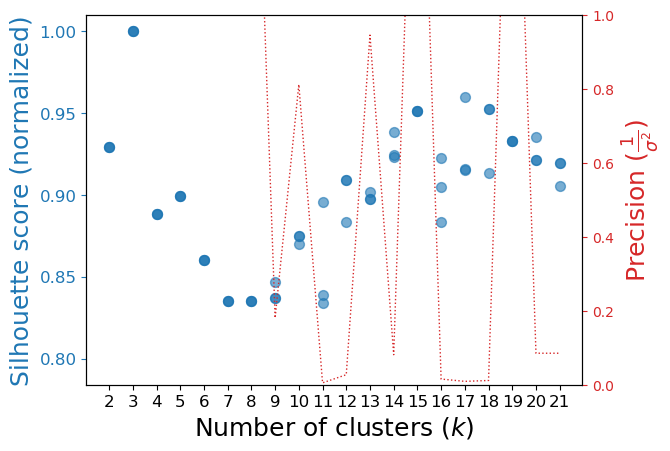

In [6]:
best_k = kutils.bestSilScores(network_silScores, 20)

While there are some high silhouette scores across many different k values, the most consistent scores are for low k values. Since the highest and most consistent silhouette score is at k=3, that's what we'll use.

Using k=3, let's take a look at how consistent the cluster assignments were across iterations.

network_consistency = kutils.bestSolution(network_kmeans, best_k, seed_list)
network_consistency

The "Best cluster assignment" column indicates the cluster to which each row was assigned to. The "Percentage..." column indicates consistent this cluster assignment was over iterations. 

As hinted by the silhouette score plot, k=3 seems to lead to an extremely stable clustering solution.

In [ ]:
## Plotting
We can also see how this looks on the brain.

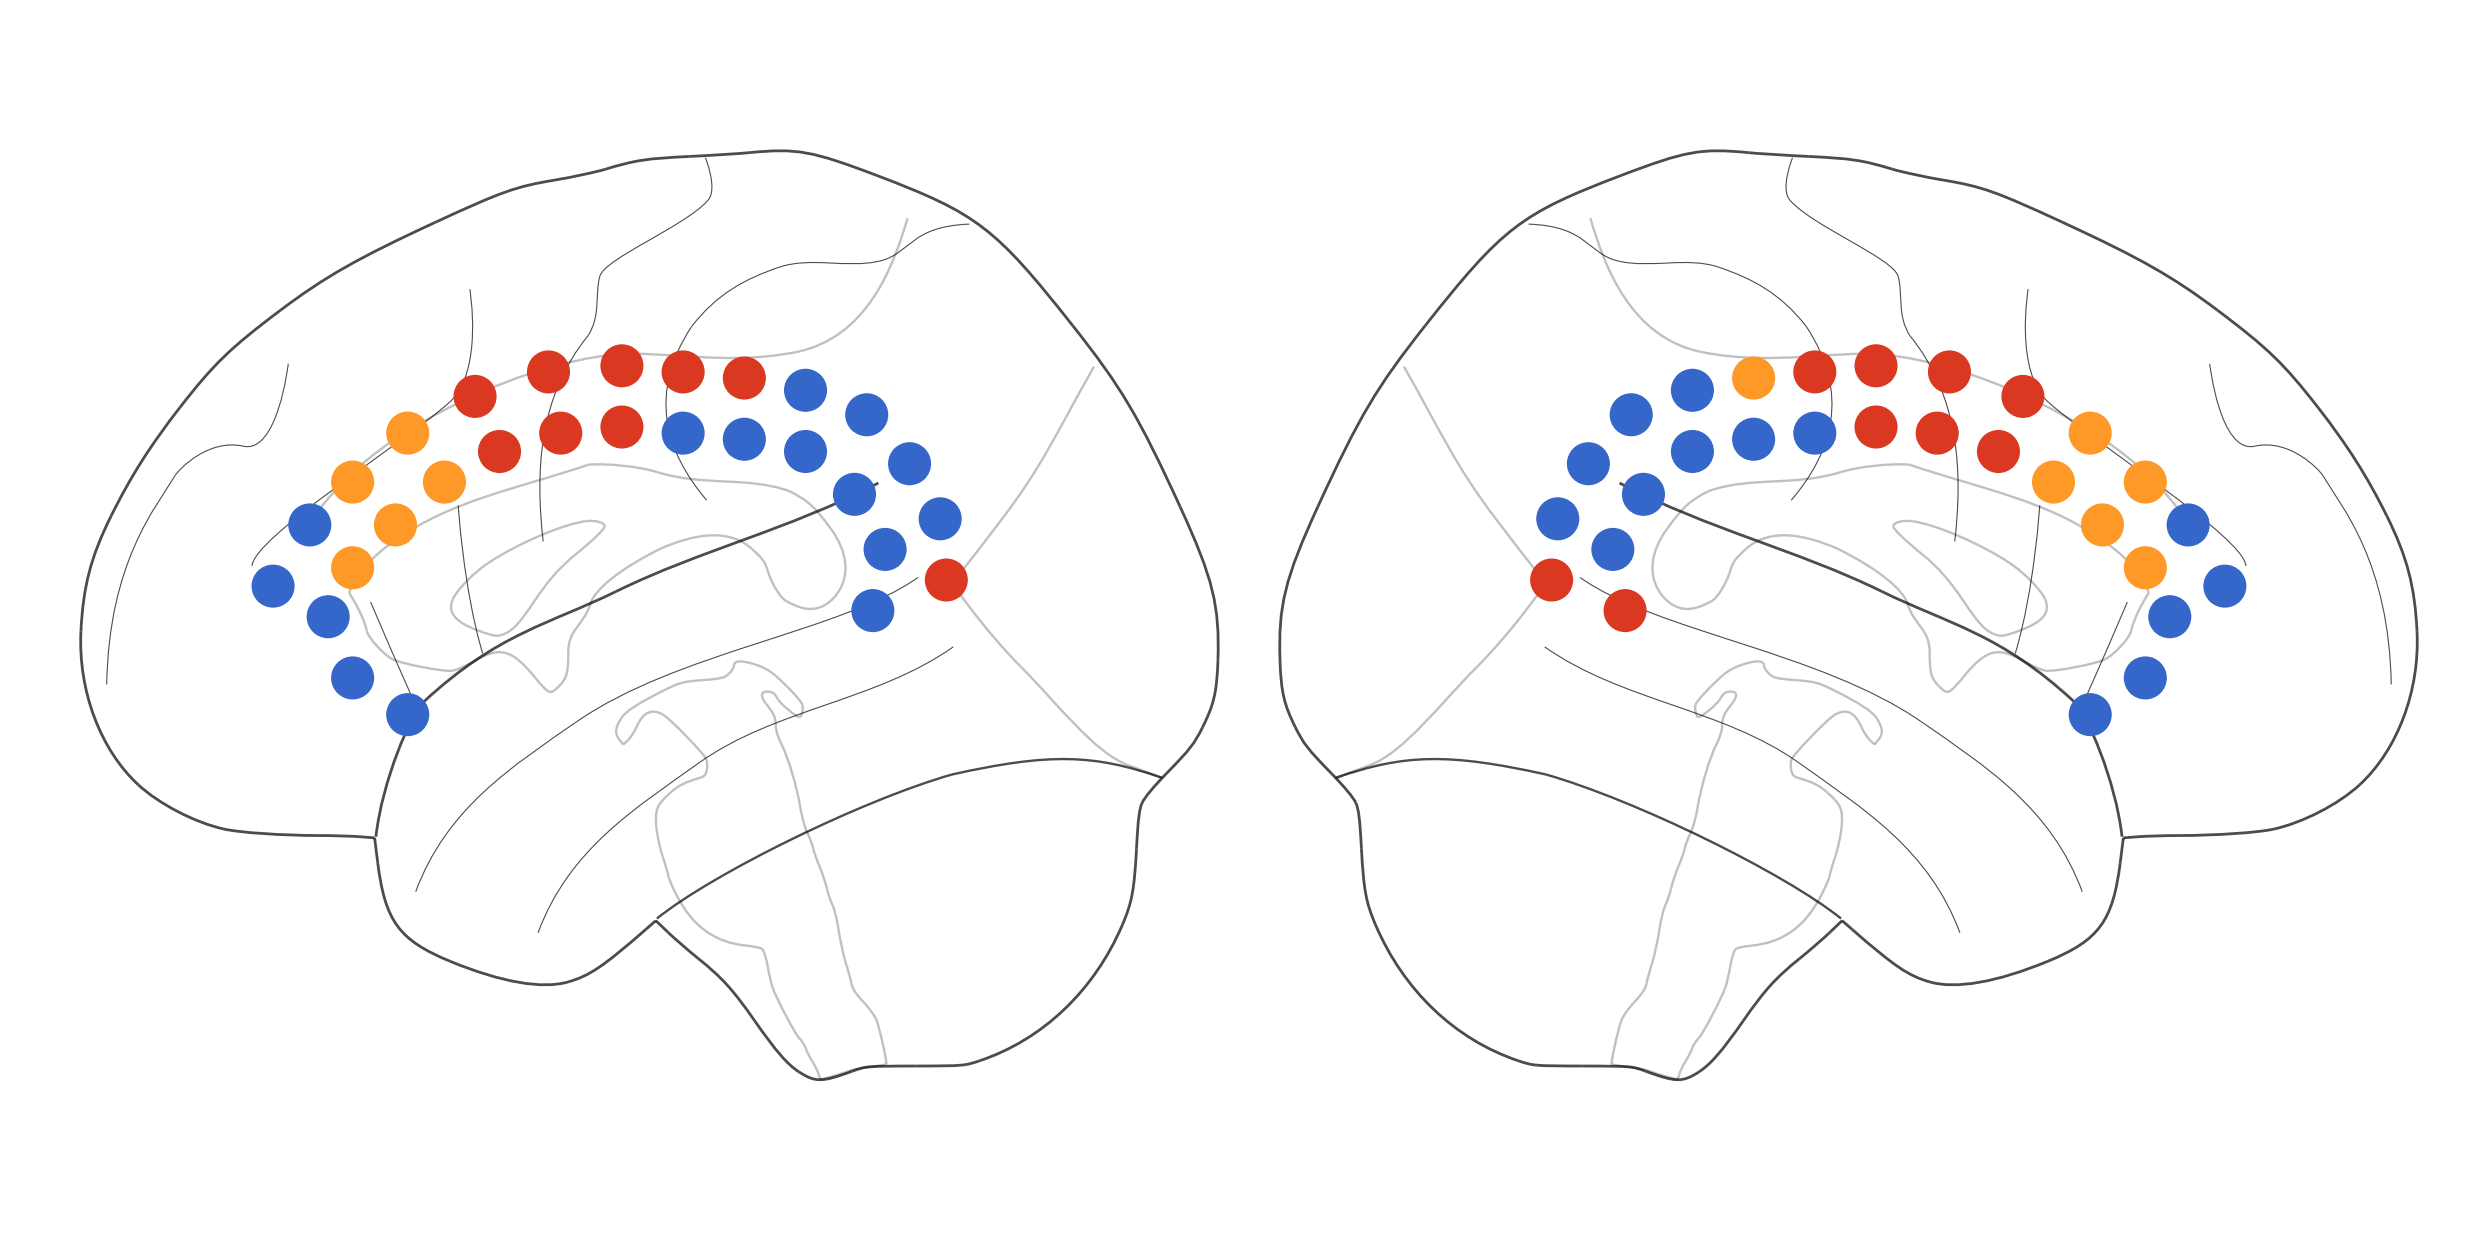

In [8]:
colors = putils.node_color_generator(palette, network_consistency.values[:, 0])
putils.plotBrains2(seed_coords, colors)

As a demonstration of how stable the k=3 solution is, we'll plot the results of running k-means 256 times.

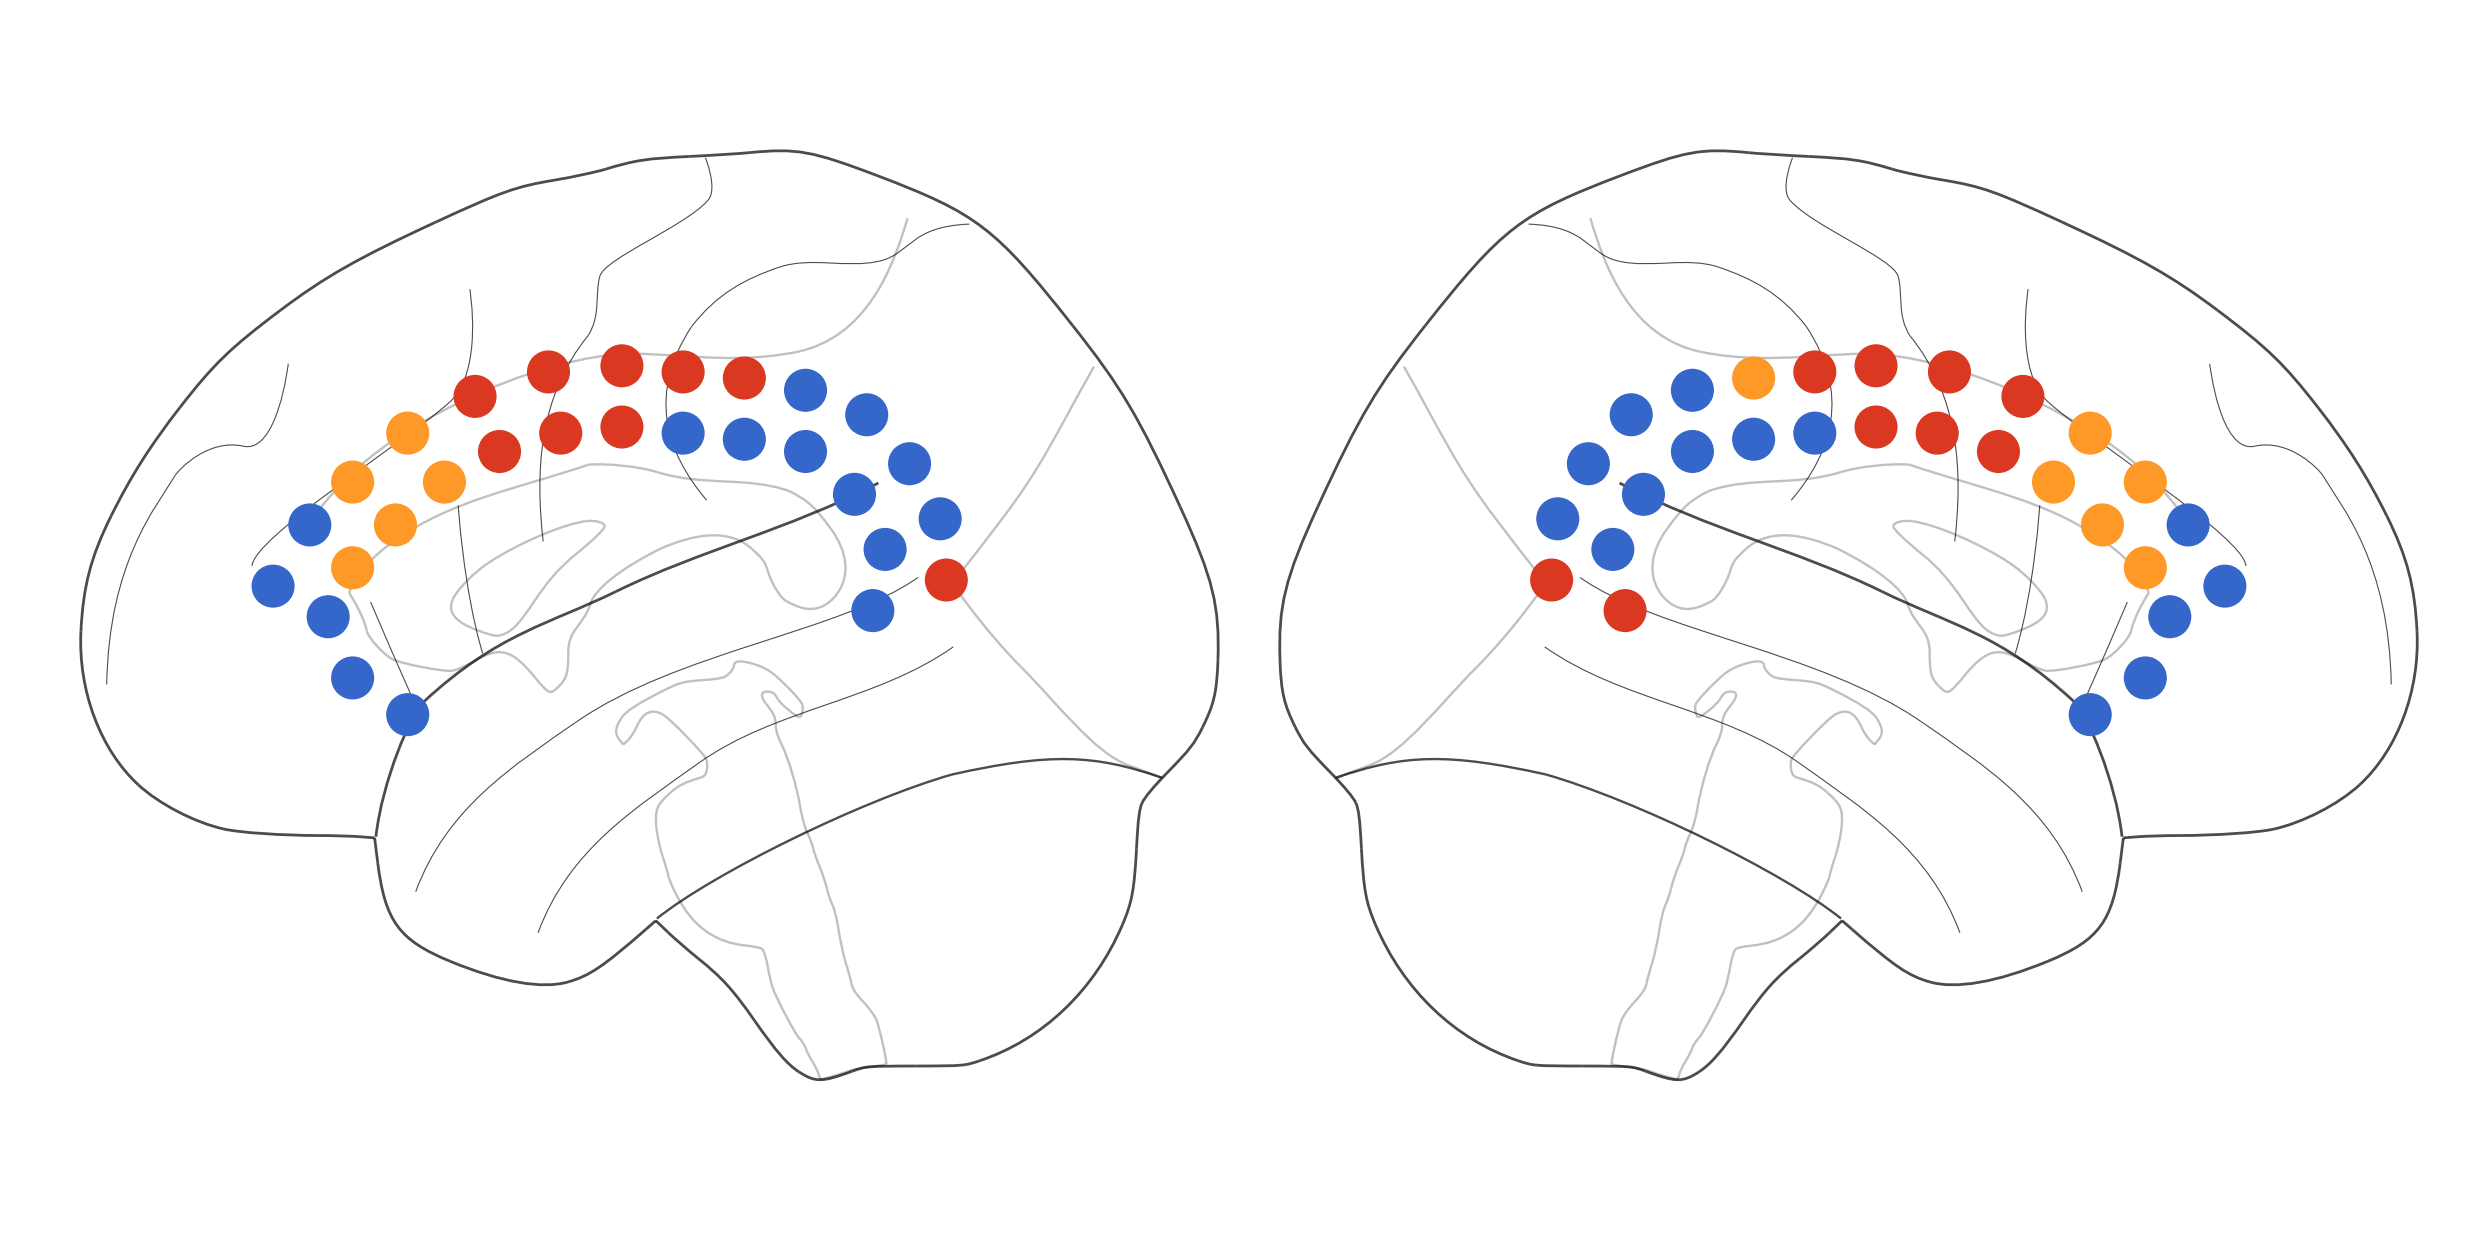

In [2]:
with open(r"./notebook_data/seed_networks_results.pkl", 'rb') as file:
    seed_networks_256 = pkl.load(file)
seed_networks_km_data = seed_networks_256['km'] #Getting k-means results

best_k = 3
network_consistency_256 = kutils.bestSolution(seed_networks_km_data, best_k, seed_list)

colors = putils.node_color_generator(palette, network_consistency_256.values[:, 0])
putils.plotBrains2(seed_coords, colors)

The previous clustering solutions were based on the similarity of the seeds' whole brain connectivity to known resting state networks. It is also possible to cluster the seeds based on their meta-analytic profiles. Here, we've used code from de la Vega et al. 2016, (https://github.com/adelavega/neurosynth-mfc) to generate functional preference profiles for each seed.

In [3]:
fpp_df = pd.read_csv(r"./notebook_data/seed_functional_profiles.csv", index_col=0)
fpp_df.head() #Show only first 5 rows

,stress,vision-shape,episodic memory,object recognition,motor,attention,gaze,learning,social,math,...,LTM,action,reasoning,fear,gustation,WM,motion,pain,sensory,spatial processing
PCC_inferior1_R,0.076583,-0.802385,0.168700,-0.051620,-0.060226,-0.165118,-0.116539,0.004770,0.469108,-0.682942,...,0.340614,-0.201401,-0.288179,0.229342,-0.100204,-0.064616,-0.417947,0.694398,-0.461613,-0.375163
PCC_inferior2_R,0.035371,-0.553129,0.835246,-0.297439,-0.523381,-0.270446,-0.395326,0.099368,-0.031725,-0.110845,...,0.578226,0.063554,0.165146,0.131848,0.193335,-0.143401,-0.594569,0.431947,-0.495906,-0.501932
PCC_inferior3_R,0.187892,-0.285735,0.632554,0.052720,-0.231009,-0.095547,-0.415414,-0.359190,0.194446,0.134678,...,0.618272,0.137813,0.078646,-0.285053,0.153424,0.085019,-0.643921,0.113599,-0.365442,-0.207887
PCC_inferior4_R,-0.094368,-0.431455,1.020655,0.065411,-0.645681,-0.122283,-0.655972,-0.175099,0.728939,-0.120945,...,0.362441,-0.765034,-0.170448,0.092345,-0.569645,0.196670,-0.961121,-0.114983,-0.275060,-0.554124
PCC_inferior5_R,0.039335,-0.323749,1.706304,0.101629,-0.700775,-0.198463,-0.956984,-0.194837,0.587818,-0.132416,...,0.549560,-1.028850,-0.782503,0.017377,0.197242,-0.006616,-0.979457,-0.325384,-0.336691,-0.587388


The columns of this data show various meta-analytic terms derived from the neurosynth database, which houses fmri-activation related data from over 14,000 studies (as of Jan 2019). Using this data we calculated another cross-correlation matrix, resulting in a symmetric 58 x 58 matrix on which to run k-means. Our silhouette score analysis also returned k=3 as the most stable solution, so we'll plot the results of that clustering on the brain.

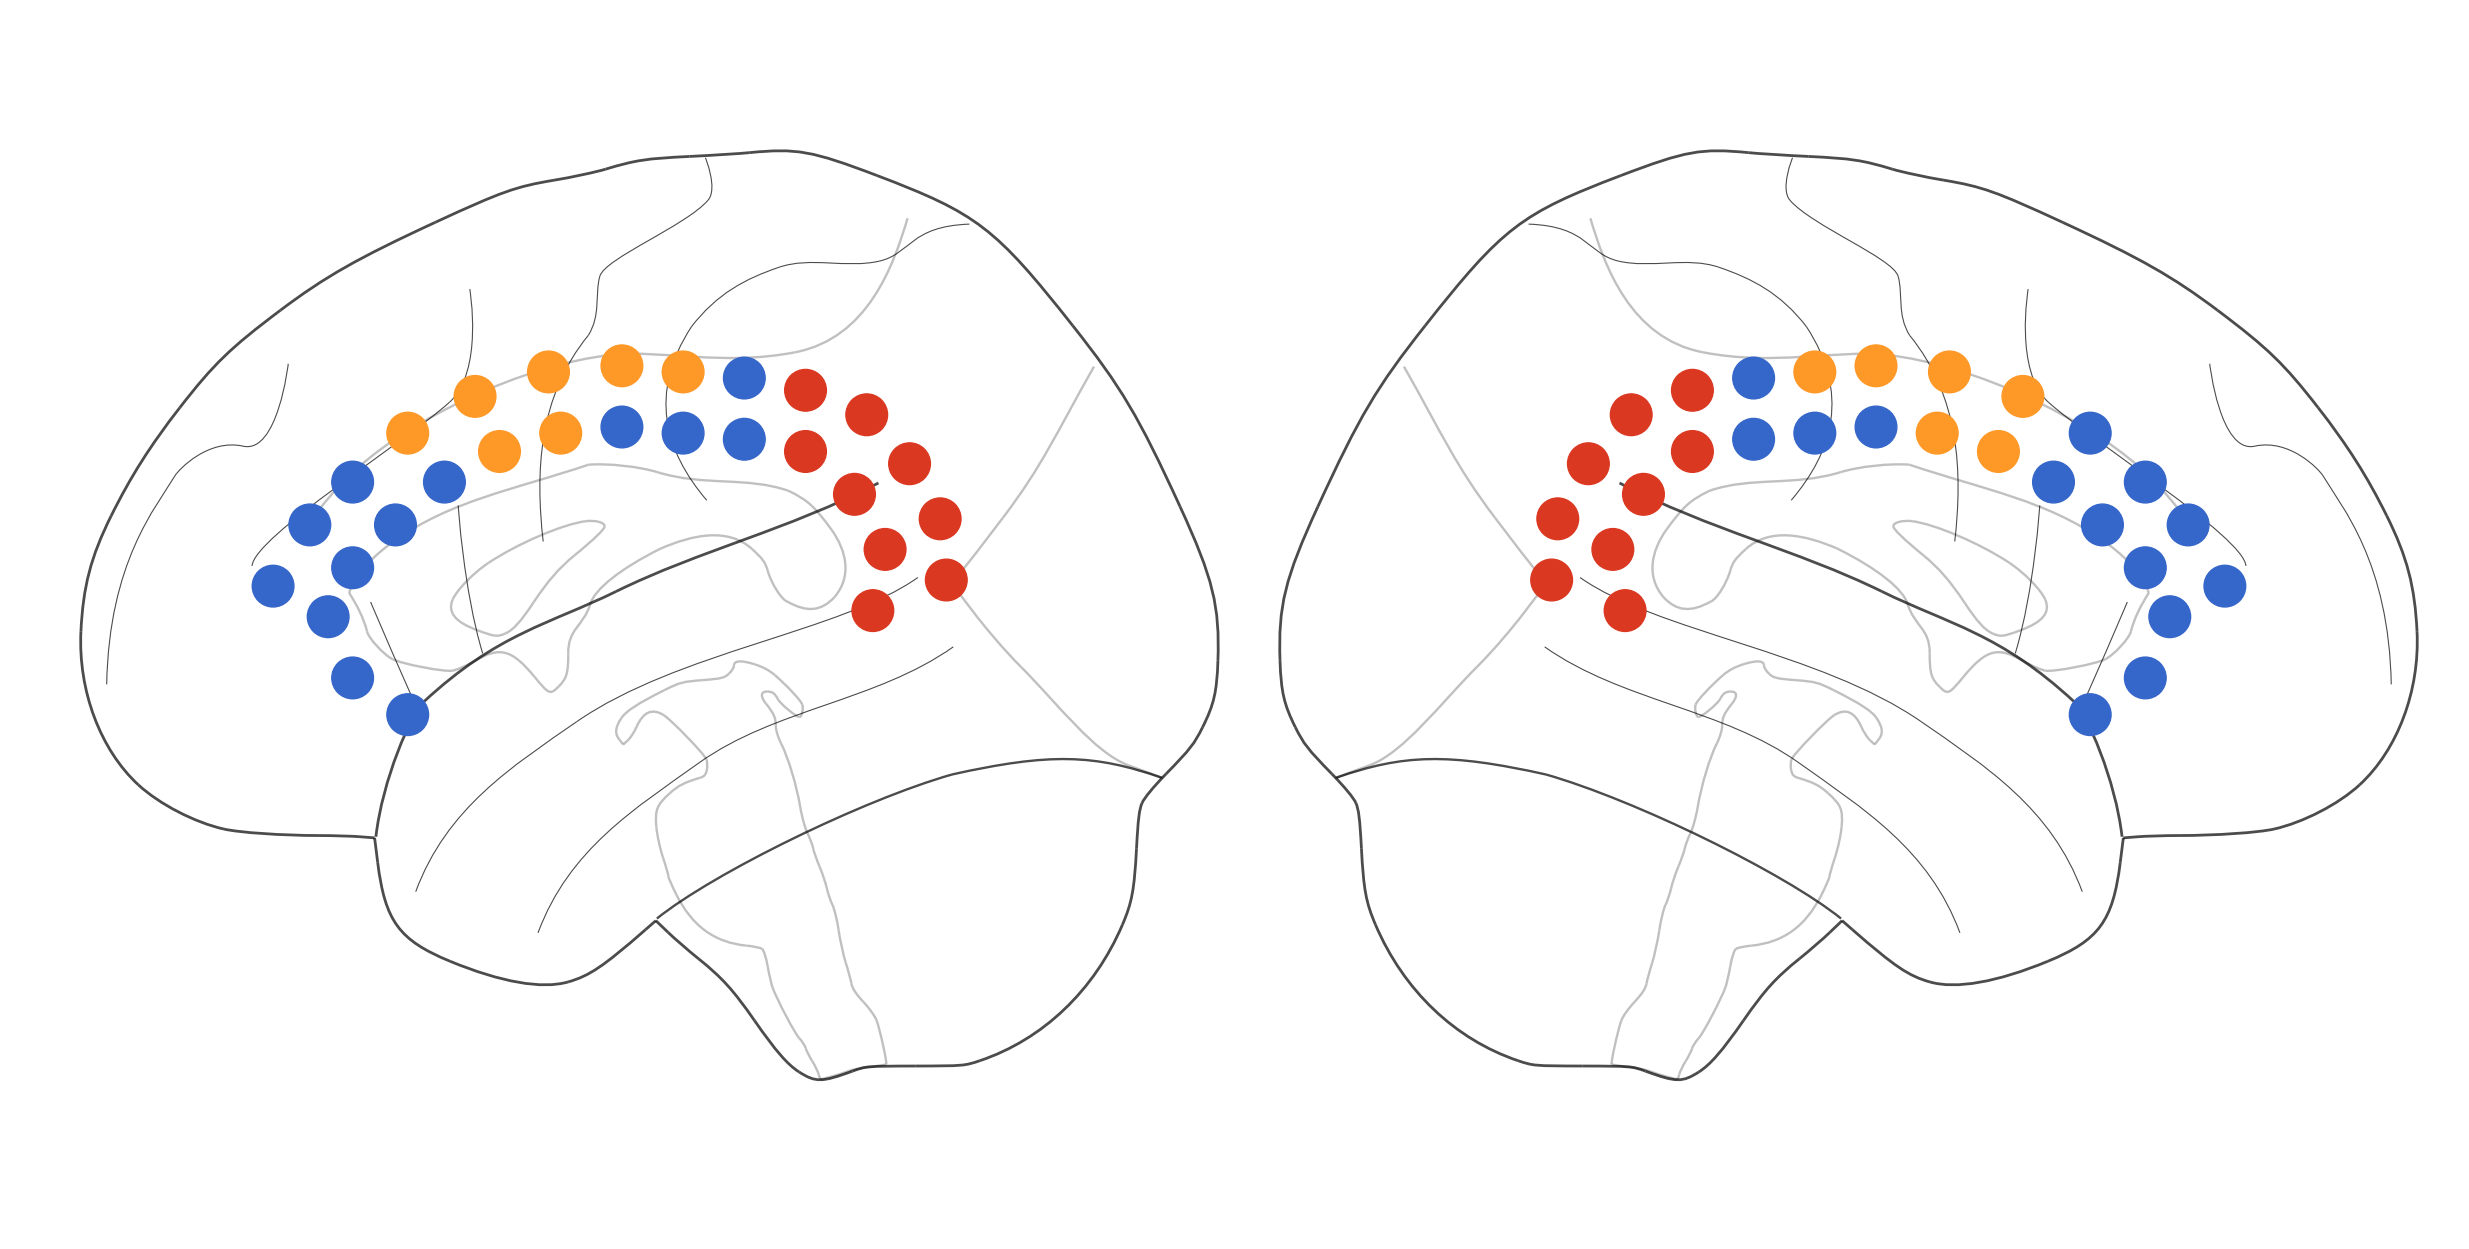

In [4]:
with open(r"./notebook_data/seed_fpp_results.pkl", 'rb') as file:
    seed_fpp_256 = pkl.load(file)
seed_fpp_km_data = seed_fpp_256['km'] #Getting k-means results

best_k = 3
fpp_consistency_256 = kutils.bestSolution(seed_fpp_km_data, best_k, seed_list)

colors = putils.node_color_generator(palette, fpp_consistency_256.values[:, 0])
putils.plotBrains2(seed_coords, colors)

Finally, we combined the two datasets into one large 58 x 116 matrix and re-ran k-means. For this matrix, the silhouette score analysis suggested that k=3 was the most stable solution, with k=2 following closely behind it.

<Figure size 640x480 with 0 Axes>

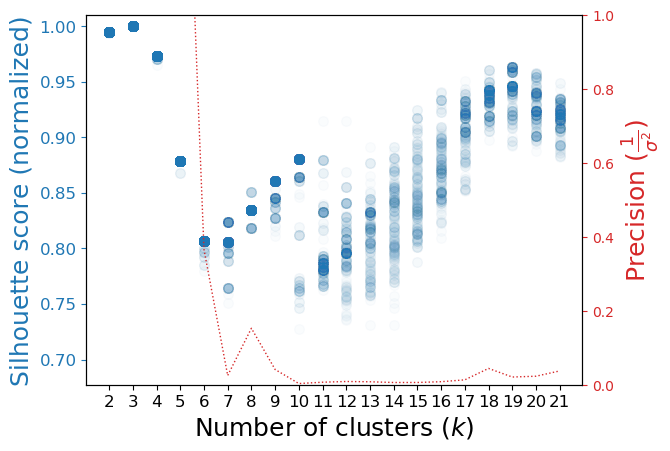

In [5]:
with open(r"./notebook_data/seed_combined_results.pkl", 'rb') as file:
    seed_combined_256 = pkl.load(file)
seed_combined_sil_scores = seed_combined_256['sil']

best_k = kutils.bestSilScores(seed_combined_sil_scores, 20)

Now let's see how the seeds were clustered when the two datasets were combined.

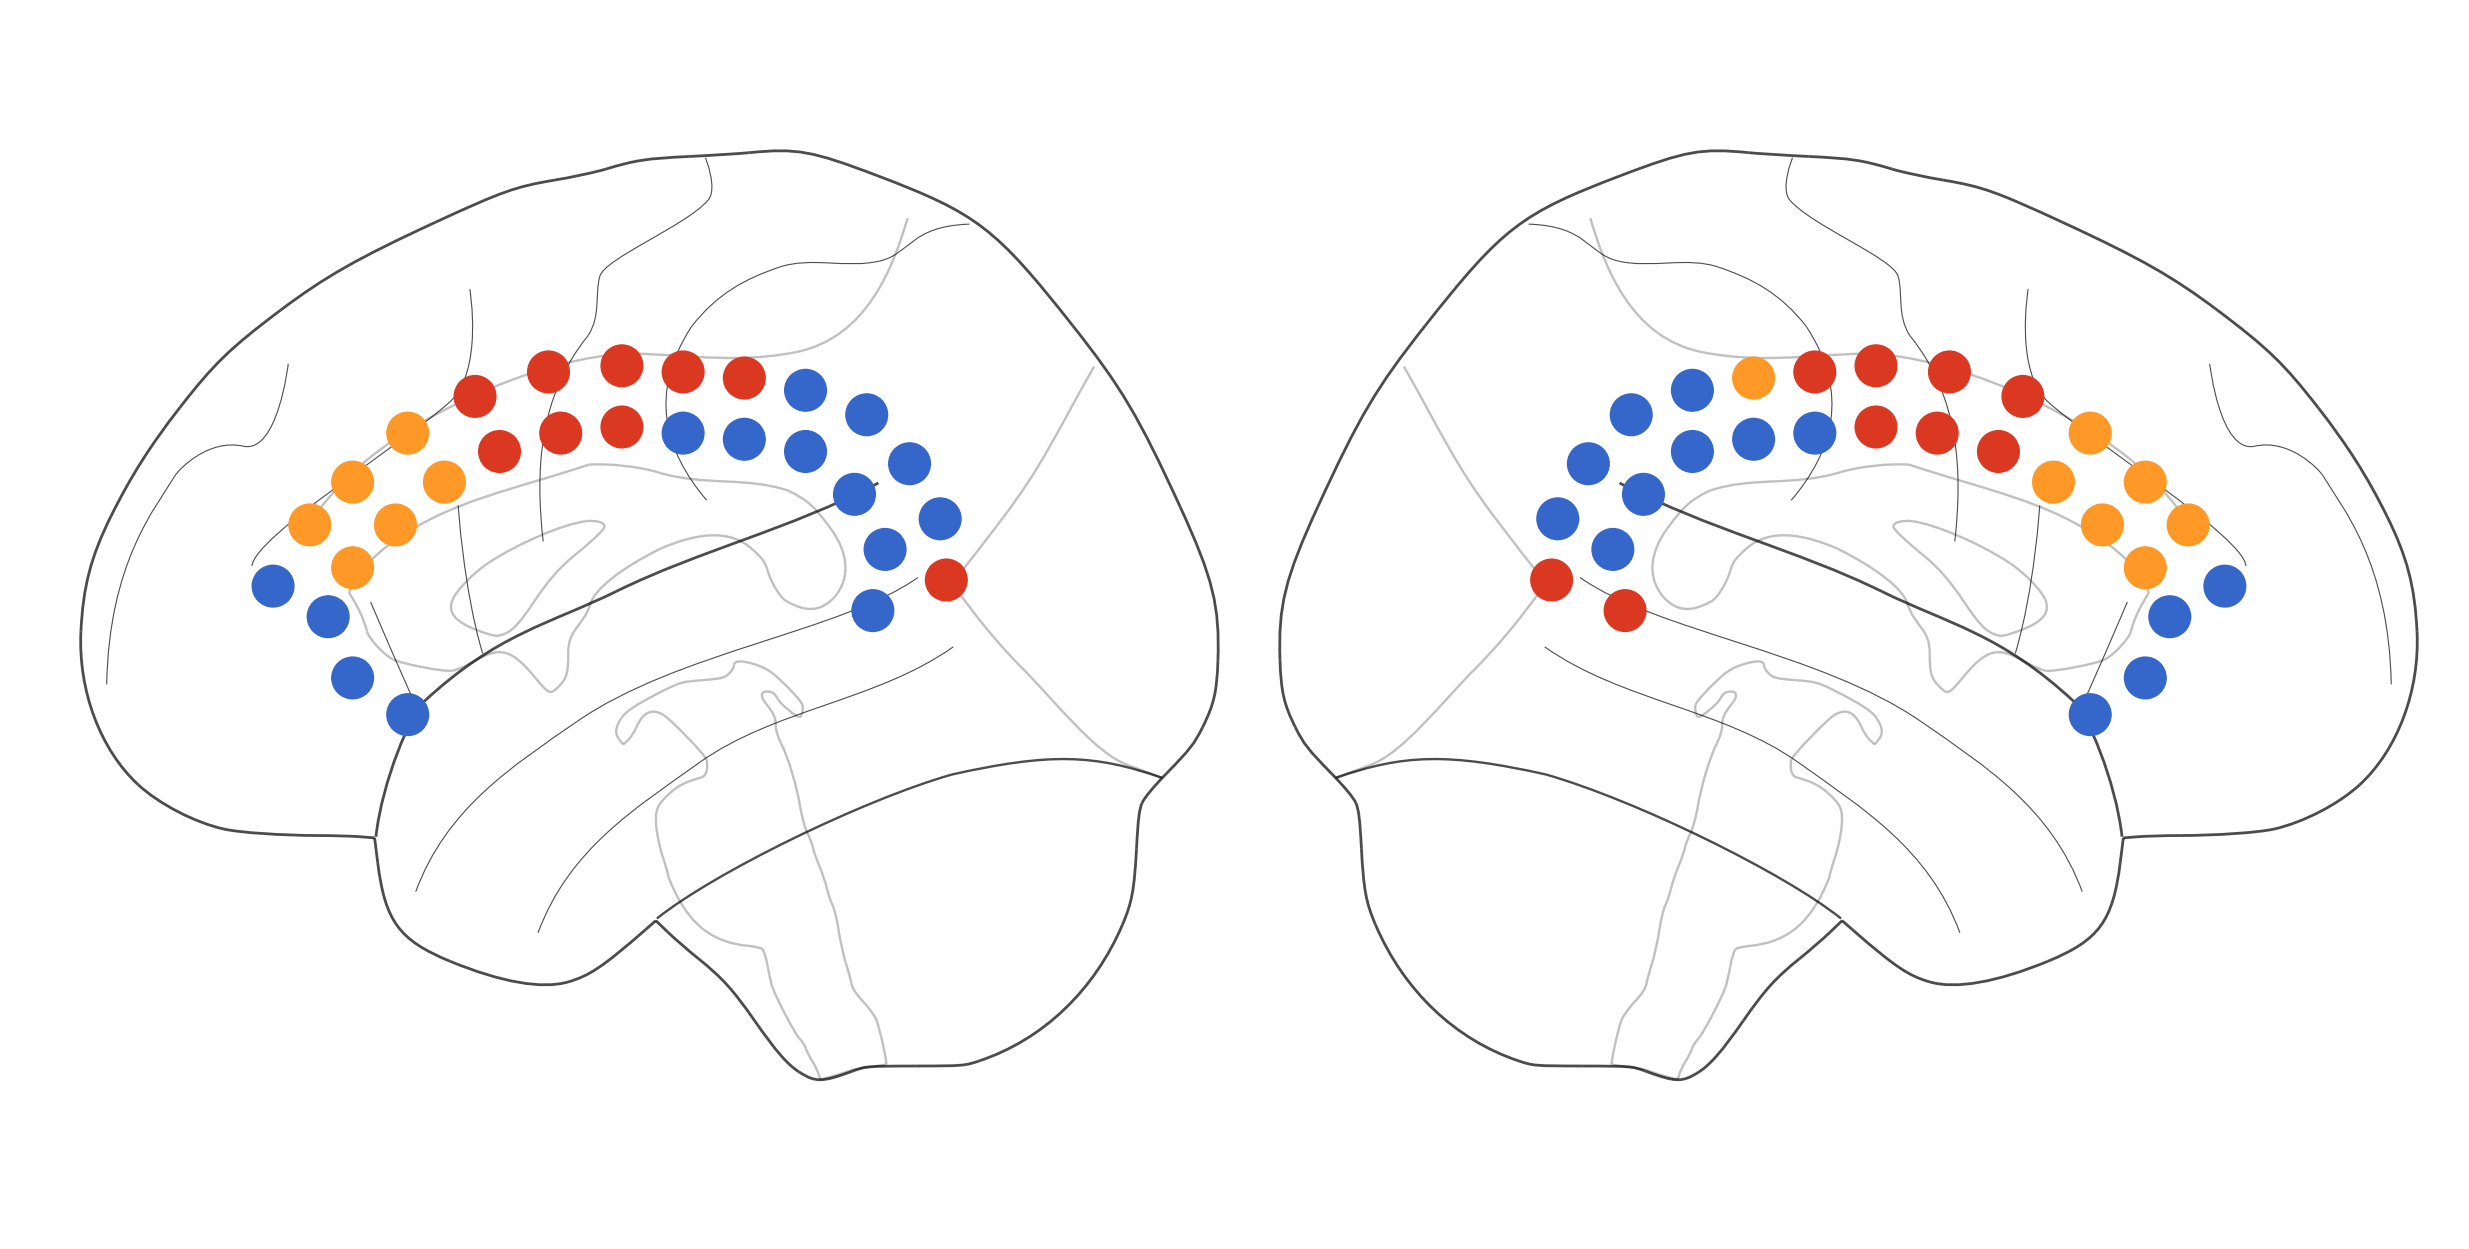

In [6]:
seed_combined_km_data = seed_combined_256['km'] #Getting k-means results

best_k = 3
combined_consistency_256 = kutils.bestSolution(seed_combined_km_data, best_k, seed_list)

colors = putils.node_color_generator(palette, combined_consistency_256.values[:, 0])
putils.plotBrains2(seed_coords, colors)